# Analyzing COS collaboration network on OSF

## Executive summary

#### Key takeaway: The majority of external collaborators return to work with COS at least once more.

This analysis evaluates the current state of one of the primary initiatives of the 2022-2025 Strategic Plan - Relationship Management - through the lens of a collaboration network on OSF centered on COS staff. Data collected via the OSF API reveals that current COS staff have first degree connections with 3,255 external collaborators. Accounting for connections based on sharing a project with Brian, only 1,449 (45%) of these connections are shown to enter the network exclusively via other staff. This result highlights the importance of developing relationships outside the established network given Brian's high centrality in it and the implied siloing of COS activities in the Psychology community.

A more encouraging result is that the majority of collaborators return to work with COS more than once, with 1,761 (54%) having at least 2 OSF projects in common with a COS staff member, including 306 who have at least 10 COS collaborations. The results of this analysis indicate that COS staff who engage with external collaborators via the OSF have demonstrated success managing relationships effectively as measured by collaborator re-engagement.

### Future directions

With the currently existing data:
- Identify possible candidates for Institutions accounts by clustering collaborators by affiliations through user profile data.
- Describe collaborator network growth over time using user and project created dates.
- Analyze frequency of tag use and content.
- Compare general COS staff behaviors on OSF by individual, department, etc.
- Play "7 degrees to Brian Nosek"

With additional data collection:
- Evaluate the impact of collaboration with COS on OSF behaviors in projects without direct COS involvement.
- Compare OSF behaviors pre- and post-collaboration with COS for users with sufficiently long activity logs.
- Match OSF profiles to engagement from individual giving campaigns to measure whether collaboration fosters direct support.
- Enhance data with additional degrees of separation from COS staff to understand peripheral connections.

### Contents

1. Data collection
2. Analysis
3. Entity relationship diagram
4. Contents of this repository
    1. Data collection and storage
    2. Other

### Data collection

Data was collected using the [OSF API](https://developer.osf.io/) in Python via the requests module.

The general approach to data collection was to begin with a [seed project](https://osf.io/api6f) to identify current COS staff, then expand outwards to collect related projects and collaborators.

The seed project identified 36 users. First, root (i.e., top-level) nodes of all of these users were gathered. Contributors and child nodes were then gathered for all root nodes.

From among the initial 36 users, only 29 are current staff. Eight additional current staff were gathered manually from the [team page](https://cos.io/about/team) of the COS website. Their user profiles were updated to be indicated as current staff in the database, and their projects and co-contributors were also gathered to ensure complete data collection based on all 37 members of the current team. The COS website also includes a list of alumni whose names were used to attempt to match against user profiles gathered incidentally over the course of data collection; including the 9 identified from the seed project, 56 alumni were found among collected users. Alumni records are not intended to be complete and some alumni may be misclassified as non-affiliates of COS; classification of this group was done coarsely as its accuracy was not a priority for this project.

The initial process was repeated once to collect contributors of child nodes and identify child nodes of known child nodes. This table describes the availability of data for each level of node organization, where (a) root, (b) child, and (c) grandchild are used to identify (a) top-level nodes, (b) child nodes under top-level nodes, and (c) child nodes under child nodes under top-level nodes.

|node type|guid|title|date created|root|parent|child|grandchild|tags|contributors|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|root|True|True|True|na|na|Possible|Possible|Possible|True|
|child|True|True|True|True|True|Possible|False|Possible|True|
|grandchild|True|True|True|True|True|False|False|False|False|

**Note:** *True* indicates that the value is required. *False* indicates that the value is expected to be missing among the collected data, but may exist on OSF. *Possible* indicates that the value is present in the data if available, but is not guaranteed to exist for every project. *na* indicates that the value does not exist.

In theory, additional levels of organization exist for some number of projects. This approach to data collection intentionally leaves them on the table to optimize the time commitment of data collection with the added value of information gathered. The operating assumption is that for projects with many levels of organization, child nodes increasingly reflect the properties of their parents, and therefore do not contribute much, if any, novel information about the identities of collaborators in this network.

The current database includes 3,424 user profiles and 9,722 nodes. The nodes may be distinguished as follows:

||n|
|:---:|:---:|
|root, no child nodes|334|
|root|664|
|child|2,662|
|grandchild|6,062|

Instructions to reproduce data collection are available in the contents of this repository section.

### Analysis

In [1]:
# setup packages
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from config import db_name
from network_functions import create_network

In [2]:
# define network features
users, edges = create_network()

In [3]:
# collapse project-level collaborations to user-pair frequencies
edges_summary = edges.groupby(['internal', 'external']).count().reset_index()
edges_summary.rename({'project_guid': 'num_projects'}, axis=1, inplace=True)

In [4]:
# restrict connections to those based on current staff only
current_staff = users[users.is_cos==1]
current_connections = pd.merge(current_staff, edges_summary, how='left', left_on='guid', right_on='internal')

# how many external collaborators are in our network from current staff?
current_collabs = len(current_connections[current_connections.external.notna()].external.unique())
current_collabs

3255

In [5]:
# how many external collaborators are in our network via current staff other than Brian (cdi38)?
# identify all nodes where Brian is in the project hierarchically somewhere
conn = sqlite3.connect(db_name)
cur = conn.cursor()
cur.execute(
    """
    SELECT nc.node,
           nr1.parent,
           nr2.parent
      FROM node_contributors nc
      LEFT JOIN node_relations nr1
           ON nc.node=nr1.child
      LEFT JOIN node_relations nr2
           ON nr1.parent=nr2.child
     WHERE nc.user="cdi38";
    """
)
brian_nodes = cur.fetchall()
conn.close()

brian_nodes_set = set()
for n in brian_nodes:
    for i in n:
        brian_nodes_set.add(i)

In [6]:
# filter Brian-related projects out of consideration, repeat summary
edges_extended = edges.copy()

edges_extended['has_brian'] = edges_extended.project_guid.isin(brian_nodes_set)
no_brian = edges_extended[~edges_extended.has_brian]
edges_summary_no_brian = no_brian.groupby(['internal', 'external']).count().reset_index()
edges_summary_no_brian.rename({'project_guid': 'num_projects'}, axis=1, inplace=True)
current_connections_no_brian = pd.merge(current_staff, edges_summary_no_brian, how='left', left_on='guid', right_on='internal')

current_collabs_no_brian = len(current_connections_no_brian[current_connections_no_brian.external.notna()].external.unique())
current_collabs_no_brian

1449

In [7]:
# and as proportion of all collabs
current_collabs_no_brian/current_collabs*100

44.516129032258064

In [8]:
# who doesn't have any connections to external collaborators on OSF?
current_connections[current_connections.external.isna()][['guid', 'full_name']]

,guid,full_name
6089,qfyex,Alexis Rice
9186,xh5r9,Lisa Cuevas Shaw


In [9]:
# redefine summary in terms of external collaborators' number of shared projects
current_edges = edges[edges.internal.isin(current_staff.guid.values)][['external', 'project_guid']].copy()
edges_summary_projects = current_edges.drop_duplicates().groupby('external').count().reset_index()
edges_summary_projects.rename({'project_guid': 'num_projects'}, axis=1, inplace=True)
projects_summary = edges_summary_projects.value_counts('num_projects')
projects_summary = projects_summary.sort_index()

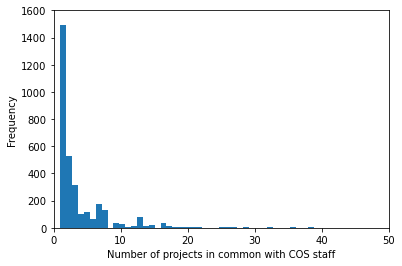

In [10]:
show_summary = edges_summary_projects['num_projects'][edges_summary_projects.num_projects < 51]
n, bins, patches = plt.hist(show_summary, bins=50, facecolor='tab:blue')

plt.xlabel('Number of projects in common with COS staff')
plt.ylabel('Frequency')
plt.xlim(0, 50)
plt.ylim(0, 1600)

plt.show()

In [11]:
# how many users have at least 2 projects in common with COS staff?
projects_summary[1:].sum()

1761

In [12]:
# and as percentage
(projects_summary.sum() - projects_summary[1].sum())/projects_summary.sum()*100

54.10138248847927

In [13]:
# what about at least 10?
projects_summary[9:].sum()

306

### Entity relationship diagram

Collected data is stored in a SQLite database with these entities. Currently, data collection method and tables for registrations and preprints are implemented but data was not collected.

![](OSF-EDA.png)

*Image not loading? Check it out at the raw [here](OSF-EDA.png).*

### Contents of this repository

#### Data collection and storage
    
To reproduce the data collection pipeline outlined above, run `collect_data.py`, `gather_staff.py`, then run `get_next_level()` (in `collect_data.py`). Depending on your setup, you may be able to take advantage of parallelization of requests to a greater extent than I was; just adjust `num_processes` wherever it appears as a parameter in the data collection functions.

##### [db_setup.py](db_setup.py)

Creates initial database and tables.

##### [user_functions.py](user_functions.py)

Defines functions to:
- request user OSF profile
- request user nodes, registrations, and preprints
- process profile to extract name, date registered, socials, employment, and education
- process resources to extract title and date created, registered, or published, respectively
- load user data into DB

##### [project_functions.py](project_functions.py)

Defines functions to:
- request node data from OSF
- request node contributors and child nodes
- process node data to extract title, tags, and date created
- process contributors to extract user profiles
- process chid nodes to extract title and date created
- load project data into DB

##### [collect_data.py](collect_data.py)
    
Uses functions from user_functions and project_functions to collect data as described above in [Data collection](#data_collection). Running as a script will collect initial data for users on seed project, their profiles and projects, and the contributors and child nodes of their projects. `get_next_level()` must be run separately to collect the second degree projects and contributors, and may be run iteratively to continue to build the network out to further and further degrees of separation from current COS staff.

##### [gather_staff.py](gather_staff.py)

Requires two resources in config: (1) a list of COS alumni (available on COS website), (2) a list of tuples of COS staff user profile entries for the cos_staff table in DB.

Attempts to identify COS alumni and updates additional current staff that were found to be missing from seed project. Fills in initial data collection (user profile and root projects) for newly added staff to curate a complete record for all current COS staff.

#### Other

Supplemental scripts are also used in the course of conducting this analysis.
    
##### config.py

The config file must contain:
- db_name: file name of local DB
- seed_project: OSF GUID of initial project used to identify starting users
- OSF_PAT: OSF PAT for API authentication
- base_url: OSF API base URL - 'https://api.osf.io/v2'

To complete records for current COS staff, it must also contain:
- cos_alumni: a list of COS alumni (available on COS website)
- staff_insert: a list of tuples of COS staff user profile entries for the cos_staff table in DB
    
##### [network_functions.py](network_functions.py)

Contains one function, `create_network()` which queries DB to gather the majority of relevant data for analysis and returns pandas DataFrames for convenient use thereafter.